In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [4]:
# Read all data files of one category.
import os

trajectories_per_category = {}
categories = ['alive', 'fibro', 'plastic']
downsample_steps = [2, 5, 5]
for category, downsample_step in zip(categories, downsample_steps):
    data_dir = 'data/JulianTrajs/' + category
    trajectories_per_category[category] = []  # dimensions: trajectory index -> time step -> coordinate (x, y, z)
    filenames = os.listdir(data_dir)    
    for filename in filenames:
        trajectory = np.genfromtxt(os.path.join(data_dir, filename))
        for start in range(downsample_step):
            end = -(downsample_step - start)
            sliced_trajectory = trajectory[start:end:downsample_step]
            trajectories_per_category[category].append(sliced_trajectory)
    trajectories_per_category[category] = np.array(trajectories_per_category[category])
    print "Category {}: Found {} files, created {} trajectories".format(category, len(filenames), len(trajectories_per_category[category]))

Category alive: Found 65 files, created 130 trajectories
Category fibro: Found 69 files, created 345 trajectories
Category plastic: Found 177 files, created 885 trajectories


In [5]:
# Convert to velocities (um / min).
for category in trajectories_per_category:
    trajectories_per_category[category] = np.diff(trajectories_per_category[category], axis=1) / 5.

In [6]:
# Normalize trajectories to [-1, 1] for the LSTM network (it outputs values between -1 and 1 by default)
# TODO: Do not use min/max values here but fixed value to generalize to other datasets.
min_value = np.min([np.min(traj) for traj in trajectories_per_category.values()])
max_value = np.max([np.max(traj) for traj in trajectories_per_category.values()])
for category in trajectories_per_category:
    trajectories_per_category[category] = np.interp(trajectories_per_category[category], [min_value, max_value], [-1., 1.])

In [201]:
# TODO: Split into training/test data here.
# TODO: Possible to use validation data in this scenario?


# Split trajectories into short parts following. Save the next position for each part.
# See also https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py

category = 'fibro'
maxlen = 20  # Change this to see how strong the current position depends on the positions long ago. REPHRASE THIS
step = 3  # Change this to vary redundancy. 
mini_trajectories = []
next_values = []

for trajectory in trajectories_per_category[category]:
    for i in range(0, len(trajectory) - maxlen, step):
        mini_trajectories.append(trajectory[i:i+maxlen])
        next_values.append(trajectory[i+maxlen] - trajectory[i])
        
mini_trajectories = np.array(mini_trajectories)
next_values = np.array(next_values)

print 'Created', len(mini_trajectories), 'data samples for category', category

Created 20700 data samples for category fibro


In [12]:
mini_trajectories[0], next_values[0]

(array([[-0.10088609,  0.13456223, -0.19948066],
        [ 0.04993788,  0.07496309,  0.00100353],
        [ 0.05005062,  0.07961202,  0.05077003],
        [ 0.03791768,  0.01855202,  0.03857294],
        [ 0.04290732,  0.032297  , -0.0061077 ],
        [ 0.04273715, -0.02938621,  0.09316137],
        [ 0.05251024,  0.03013426,  0.0532063 ],
        [ 0.0871389 ,  0.11659996,  0.03805205],
        [-0.00470329, -0.06698778,  0.09544406],
        [ 0.08972384,  0.02300949, -0.05886761],
        [-0.05419032, -0.06297569,  0.09594482],
        [ 0.03376743,  0.02785516,  0.03446003],
        [-0.0033924 , -0.07523348,  0.09680817],
        [ 0.00589187, -0.05645695,  0.00671773],
        [ 0.04933545,  0.0382119 ,  0.05011497],
        [ 0.04588327, -0.03247633,  0.0465939 ],
        [ 0.01201921,  0.01248308,  0.0126648 ],
        [ 0.05564509, -0.0677677 ,  0.15613886],
        [ 0.04153975, -0.01994529,  0.04228925],
        [ 0.04502883,  0.03162549, -0.00394708]]),
 array([ 0.1026691

In [13]:
# Set up the network.
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM

model = Sequential()

# TODO: Try stateful for the same trajectory
# TODO: Play around with output_dim here. 
model.add(LSTM(input_dim=3, output_dim=10, return_sequences=True))  # TODO: Is it possible to use input_dim here and omit maxlen?
#model.add(Dropout(0.3))
#model.add(LSTM(output_dim=10, return_sequences=True))
model.add(LSTM(output_dim=3, return_sequences=False))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

Using Theano backend.
D:\Python\27_32bit\lib\site-packages\theano\tensor\signal\downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [171]:
# Train the model.
model.fit(mini_trajectories, next_values, nb_epoch=100, batch_size=15, verbose=1)

# TODO: See if GPU is better for RNN (according to keras docs)
# TODO: Play with batch_size
# TODO: Other implementation: learn on single trajectory, X = trajectory[:-1], y = trajectory[1:], then repeat this for the other trajectories
#       Input and output dimension 3 in this case; does the network have to be stateful?

# TODO: How is the accuracy calculated here?

Epoch 1/100
11570/11570 [==============================] - 18s - loss: 0.0045    
Epoch 2/100
11570/11570 [==============================] - 15s - loss: 0.0045    
Epoch 3/100
11570/11570 [==============================] - 15s - loss: 0.0045    
Epoch 4/100
11570/11570 [==============================] - 17s - loss: 0.0045    
Epoch 5/100
11570/11570 [==============================] - 18s - loss: 0.0045    
Epoch 6/100
11570/11570 [==============================] - 18s - loss: 0.0045    
Epoch 7/100
11570/11570 [==============================] - 16s - loss: 0.0045    
Epoch 8/100
11570/11570 [==============================] - 15s - loss: 0.0045    
Epoch 9/100
11570/11570 [==============================] - 15s - loss: 0.0044    
Epoch 10/100
11570/11570 [==============================] - 15s - loss: 0.0044    
Epoch 11/100
11570/11570 [==============================] - 15s - loss: 0.0044    
Epoch 12/100
11570/11570 [==============================] - 17s - loss: 0.0044    
Epoch 13/100


In [172]:
# Test the model predictions on the training data. 
predicted = np.interp(model.predict(mini_trajectories), [-1., 1.], [min_value, max_value])
expected = np.interp(next_values, [-1., 1.], [min_value, max_value])

In [173]:
zip(predicted[100:120], expected[100:120])

[(array([ 0.14461765, -0.51404623,  0.07304066]),
  array([-0.0566044 ,  0.4369784 , -0.05458234])),
 (array([-0.29417282,  1.41887873, -0.22574433]),
  array([-0.5596472 , -0.0719732 , -0.55970654])),
 (array([ 0.38265051, -0.08209987, -0.04645106]),
  array([ 0.320808  , -0.2064702 , -0.71425712])),
 (array([-0.29277008,  0.38033264, -0.59325268]),
  array([-0.4147234 ,  0.4687694 , -0.93699054])),
 (array([-0.23628552, -0.14015721,  0.27308771]),
  array([-0.432894 ,  1.0568668,  0.0836915])),
 (array([-0.22119767,  0.07016583, -0.41390836]),
  array([-1.0017576, -0.4835314,  0.0333258])),
 (array([-0.19640415, -0.57749223, -0.21222711]),
  array([-0.3770274 , -2.7072256 , -0.37948692])),
 (array([-0.29360311, -0.17884346, -0.00330536]),
  array([-1.3737564 , -0.8301308 ,  0.17770652])),
 (array([-0.29686537,  1.09617428,  0.05926868]),
  array([-0.423287  ,  1.8435914 , -0.93940764])),
 (array([-0.31806551, -0.19374616, -0.39089531]),
  array([-0.384137  , -0.320176  , -0.38600444]

In [174]:
# Rough measure for deviation.
np.sum(np.abs(predicted - expected)) / len(predicted) / 3.
# TODO: Compare with constant or random predictor

0.49749000747140387

In [29]:
# TODO: Other possible idea: Make matrix around current position with probabilities as output
# TODO: CLassification: feed in points step by step, see how classification probability changes
# TODO: Make the network predict persistence etc

In [34]:
# Constant predictor (take last position of trajectory as prediction for next position).
last_positions = mini_trajectories[:, -1]
constant_predicted = np.interp(last_positions, [-1., 1.], [min_value, max_value])
np.sum(np.abs(constant_predicted - expected)) / len(predicted) / 3.

0.99501075332619038

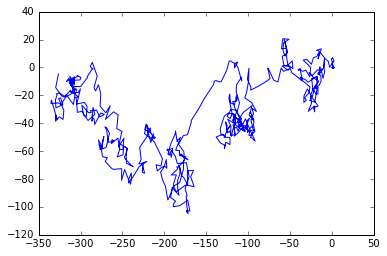

In [182]:
# Predict new trajectory by using one mini trajectory as seed.
num_predictions = 557

seed = mini_trajectories[np.random.randint(len(mini_trajectories))]
generated_trajectory = list(seed)

for i in range(num_predictions):
    next_value = model.predict(seed[np.newaxis])[0]  # TODO: Maybe introduce some randomness/temperature.
    next_value += (np.random.rand(3) - 0.5) 
    
    #print next_value[0]
    generated_trajectory.append(next_value)
    seed = np.append(seed, next_value[np.newaxis], axis=0)[1:]

    
generated_trajectory = np.array(generated_trajectory)
generated_trajectory = np.interp(generated_trajectory, [-1., 1.], [min_value, max_value])
generated_trajectory = np.cumsum(generated_trajectory, axis=0) - generated_trajectory[0]
plt.plot(generated_trajectory[:, 0], generated_trajectory[:, 1])

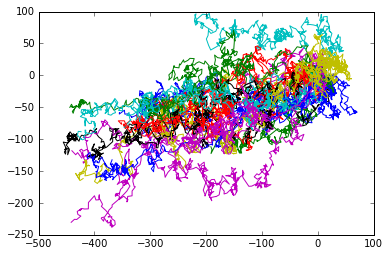

In [183]:
for i in range(20):    
    num_predictions = 557

    seed = mini_trajectories[np.random.randint(len(mini_trajectories))]
    generated_trajectory = list(seed)

    for i in range(num_predictions):
        next_value = model.predict(seed[np.newaxis])[0]  # TODO: Maybe introduce some randomness/temperature.
        next_value += (np.random.rand(3) - 0.5) 
        #print next_value[0]
        generated_trajectory.append(next_value)
        seed = np.append(seed, next_value[np.newaxis], axis=0)[1:]

    generated_trajectory = np.array(generated_trajectory)
    generated_trajectory = np.interp(generated_trajectory, [-1., 1.], [min_value, max_value])
    generated_trajectory = np.cumsum(generated_trajectory, axis=0) - generated_trajectory[0]
    plt.plot(generated_trajectory[:, 0], generated_trajectory[:, 1])


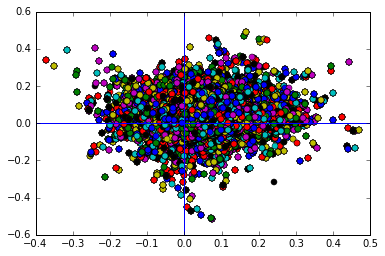

In [202]:
for mt in mini_trajectories:
    plt.plot(mt[:, 0], mt[:, 1], 'o')
plt.axvline(0)
plt.axhline(0)

In [191]:
mini_trajectories[:, :, 0].shape

(11570, 20)

In [206]:
rt = np.cumsum(mini_trajectories[0:1], axis=1)
for r in rt:
    plt.plot(r[:, 0], r[:, 1])

Error in callback <function post_execute at 0x059DBBB0> (for post_execute):


MemoryError: In RendererAgg: Out of memory

MemoryError: In RendererAgg: Out of memory

In [199]:
rt

array([[[ -1.00886088e-01,   1.34562232e-01,  -1.99480660e-01],
        [  4.99378806e-02,   7.49630884e-02,   1.00352903e-03],
        [  5.00506161e-02,   7.96120208e-02,   5.07700299e-02],
        ..., 
        [  5.56450851e-02,  -6.77676958e-02,   1.56138862e-01],
        [  4.15397535e-02,  -1.99452890e-02,   4.22892472e-02],
        [  4.50288287e-02,   3.16254929e-02,  -3.94708306e-03]],

       [[ -6.29684095e-02,   1.53114249e-01,  -1.60907717e-01],
        [  9.28451975e-02,   1.07260085e-01,  -5.10417491e-03],
        [  9.27877681e-02,   5.02258104e-02,   1.43931399e-01],
        ..., 
        [  5.74281146e-02,  -8.98390092e-02,   2.58169713e-01],
        [  7.74419795e-02,  -9.55362609e-02,   7.89112495e-02],
        [ -1.94003078e-02,  -4.71421446e-02,   1.31329448e-01]],

       [[ -1.04581676e-02,   1.83248511e-01,  -1.07701413e-01],
        [  1.79984095e-01,   2.23860046e-01,   3.29478726e-02],
        [  8.80844803e-02,  -1.67619702e-02,   2.39375461e-01],
        